### üöÄ **`Questions & Answers`**

In [1]:
from matplotlib import pyplot as plt 
import seaborn as sns

import pandas as pd 
import config
import psycopg2
import warnings

warnings.filterwarnings('ignore')
sns.set_style("dark")

In [2]:
## Abro conexi√≥n
conn = psycopg2.connect(
    dbname = config.DATABASE,
    user = config.USER, 
    password = config.PASS,
    host = "localhost",
    port = "5432"
)

#### üìå `Pregunta 1.`

¬ø C√≥mo influyen los ingresos y el monto de cr√©dito solicitado en la probabilidad de incumplimiento ?

In [3]:
## Query 
preg_01 = pd.read_sql_query("""
WITH income_credit_bins AS (
  SELECT 
    SK_ID_CURR,
    TARGET,
    NTILE(10) OVER (ORDER BY AMT_INCOME_TOTAL) AS income_decile,
    NTILE(10) OVER (ORDER BY AMT_CREDIT) AS credit_decile
  FROM application_train
)
SELECT 
  income_decile,
  credit_decile,
  COUNT(*) AS total_clients,
  SUM(TARGET) AS total_defaults,
  ROUND(SUM(TARGET) * 1.0 / COUNT(*), 4) AS default_rate
FROM income_credit_bins
GROUP BY income_decile, credit_decile
ORDER BY income_decile, credit_decile;
""", conn)

In [4]:
heatmap_data = preg_01.pivot(index = "income_decile", columns = "credit_decile", values = "default_rate")

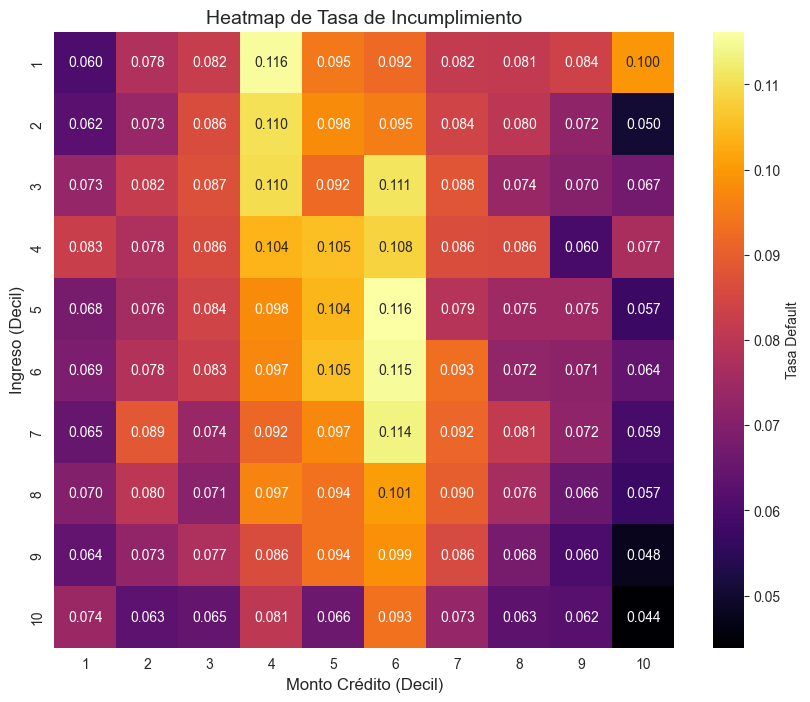

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot = True, fmt = ".3f", cmap = "inferno", cbar_kws = {'label': 'Tasa Default'})
plt.title("Heatmap de Tasa de Incumplimiento", fontsize = 14)
plt.xlabel("Monto Cr√©dito (Decil)", fontsize = 12)
plt.ylabel("Ingreso (Decil)", fontsize = 12)
plt.savefig('./figs/preg01.png', dpi = 300)
plt.show()

**`Respuesta`**: De acuerdo al heatmap, se puede apreciar los clientes con ingresos bajos y cr√©ditos moderados presentan mayor riesgo, mientras que los clientes con ingresos altos y cr√©ditos altos tienen menor probabilidad de incumplir. Esto puede ser √∫til para segmentar clientes y ajustar pol√≠ticas de cr√©dito.

#### üìå `Pregunta 2.`

¬øLos clientes con cr√©ditos previos en otras instituciones tienen un menor riesgo de incumplimiento ? 

In [6]:
## Query
preg_02 = pd.read_sql_query("""
WITH bureau_flags AS (
  SELECT 
    SK_ID_CURR,
    COUNT(*) AS total_bureau_records
  FROM bureau
  GROUP BY SK_ID_CURR
),
flags_joined AS (
  SELECT 
    a.SK_ID_CURR,
    a.TARGET,
    CASE WHEN b.total_bureau_records IS NULL THEN 0 ELSE 1 END AS has_bureau_record
  FROM application_train a
  LEFT JOIN bureau_flags b ON a.SK_ID_CURR = b.SK_ID_CURR
)
SELECT 
  has_bureau_record,
  COUNT(*) AS total_clients,
  SUM(TARGET) AS total_defaults,
  ROUND(SUM(TARGET) * 1.0 / COUNT(*), 4) AS default_rate
FROM flags_joined
GROUP BY has_bureau_record;
""", conn)

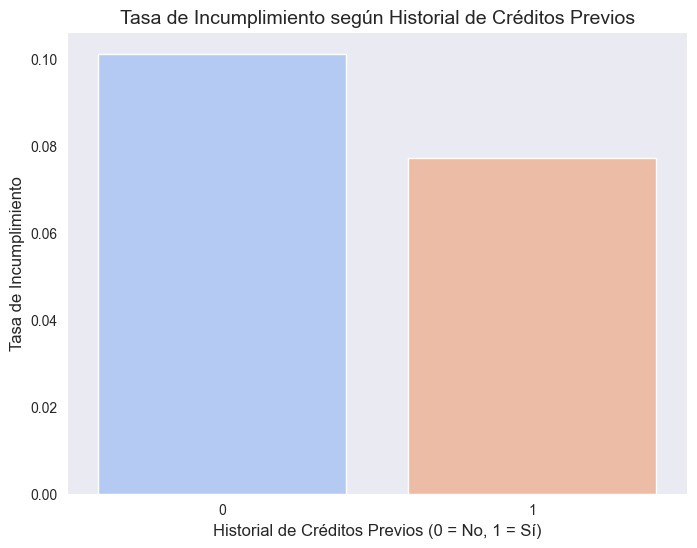

In [7]:
plt.figure(figsize = (8, 6))
sns.barplot(
    x = "has_bureau_record", 
    y = "default_rate", 
    data = preg_02, 
    palette = "coolwarm")
plt.title("Tasa de Incumplimiento seg√∫n Historial de Cr√©ditos Previos", fontsize = 14)
plt.xlabel("Historial de Cr√©ditos Previos (0 = No, 1 = S√≠)", fontsize = 12)
plt.ylabel("Tasa de Incumplimiento", fontsize = 12)
plt.savefig('./figs/preg02.png', dpi = 300)
plt.show()

**`Respuesta`:** Los datos muestran que los clientes con historial de cr√©ditos previos tienen una menor tasa de incumplimiento en comparaci√≥n con aquellos que no tienen historial, lo que podr√≠a indicar que el historial de cr√©ditos previos es un factor positivo para evaluar el riesgo de incumplimiento.

#### üìå `Pregunta 3.`

¬øC√≥mo influye el tipo de cr√©dito solicitado en la tasa de incumplimiento ? 

In [8]:
## Query
preg_03 = pd.read_sql_query("""
SELECT 
  NAME_CONTRACT_TYPE,
  COUNT(*) AS total_clients,
  SUM(TARGET) AS total_defaults,
  ROUND(SUM(TARGET) * 1.0 / COUNT(*), 4) AS default_rate
FROM application_train
GROUP BY NAME_CONTRACT_TYPE
ORDER BY default_rate DESC;
""", conn)

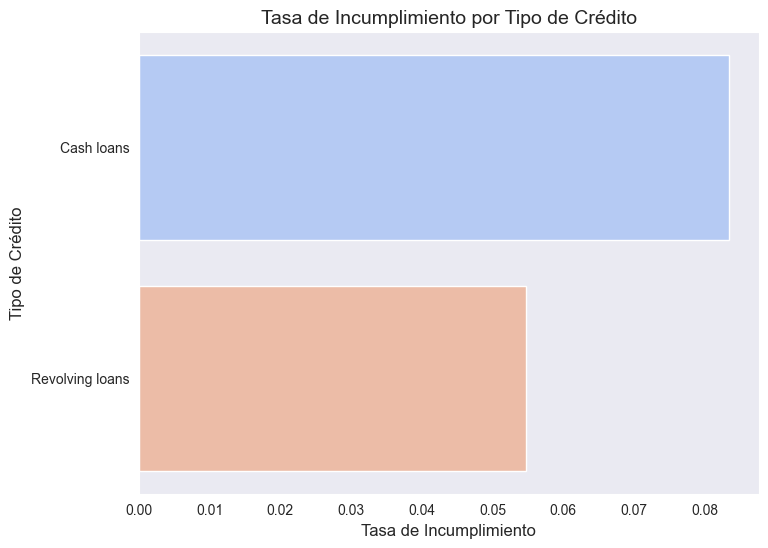

In [9]:
plt.figure(figsize = (8, 6))
sns.barplot(
    x = "default_rate", 
    y = "name_contract_type", 
    data = preg_03.sort_values(by = "default_rate", ascending = False), 
    palette = "coolwarm")
plt.title("Tasa de Incumplimiento por Tipo de Cr√©dito", fontsize = 14)
plt.xlabel("Tasa de Incumplimiento", fontsize = 12)
plt.ylabel("Tipo de Cr√©dito", fontsize = 12)
plt.savefig('./figs/preg03.png', dpi = 300)
plt.show()

**`Respuesta`:** El barplot muestra que el tipo de cr√©dito solicitado tiene una influencia significativa en la tasa de incumplimiento. En el caso de `cash loans`, al tener una tasa de incumplimiento m√°s alta, indica que clientes que solicitan pr√©stamos en efectivo, tienen mayor probabilidad de incumplir. Por otro lado,  `revolving loans` tienen tasas m√°s bajas lo cual sugiere que clientes que solicitan cr√©ditos renovables tienen menor riesgo de incumplimiento.

#### üìå `Pregunta 4.`

¬øExiste una relaci√≥n entre el saldo actual en la tarjeta de cr√©dito y el incumplimiento? 

In [10]:
## Query
preg_04 = pd.read_sql_query("""
WITH credit_balance AS (
  SELECT 
    SK_ID_CURR,
    AVG(AMT_BALANCE) AS avg_balance
  FROM credit_card_balance
  GROUP BY SK_ID_CURR
),
balance_bins AS (
  SELECT 
    a.SK_ID_CURR,
    a.TARGET,
    NTILE(10) OVER (ORDER BY c.avg_balance) AS balance_decile
  FROM application_train a
  LEFT JOIN credit_balance c ON a.SK_ID_CURR = c.SK_ID_CURR
)
SELECT 
  balance_decile,
  COUNT(*) AS total_clients,
  SUM(TARGET) AS total_defaults,
  ROUND(SUM(TARGET) * 1.0 / COUNT(*), 4) AS default_rate
FROM balance_bins
GROUP BY balance_decile
ORDER BY balance_decile;
""", conn)

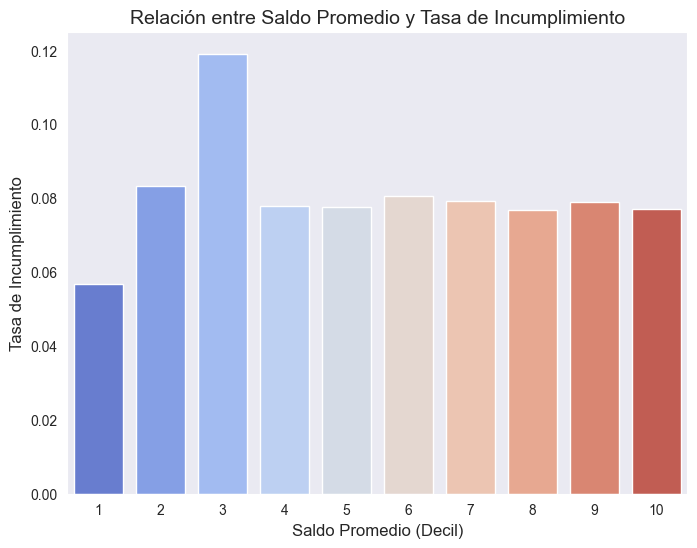

In [11]:
plt.figure(figsize=(8, 6))
sns.barplot(
    x = "balance_decile", 
    y = "default_rate", 
    data = preg_04, 
    palette = "coolwarm")
plt.title("Relaci√≥n entre Saldo Promedio y Tasa de Incumplimiento", fontsize = 14)
plt.xlabel("Saldo Promedio (Decil)", fontsize = 12)
plt.ylabel("Tasa de Incumplimiento", fontsize = 12)
plt.savefig('./figs/preg04.png', dpi = 300)
plt.show()

**`Respuesta`:** De acuerdo al gr√°fico anterior, podemos notar que no estan clara la relaci√≥n. Esto, es porque solo el decil 3 es el que presenta mayor tasa de incumplimiento, mientras que los deciles restantes (particularmente, decil 4 en adelante) presentan tasas de incumplimiento similares (aprox 8%). 

#### üìå `Pregunta 5.`

¬øLos clientes con altos niveles de uso de l√≠neas de cr√©dito tienen mayor riesgo de default ?

In [12]:
## Query
preg_05 = pd.read_sql_query("""
WITH credit_usage AS (
  SELECT 
    SK_ID_CURR,
    AVG(AMT_BALANCE / NULLIF(AMT_CREDIT_LIMIT_ACTUAL, 0)) AS avg_utilization
  FROM credit_card_balance
  WHERE AMT_CREDIT_LIMIT_ACTUAL > 0
  GROUP BY SK_ID_CURR
),
usage_bins AS (
  SELECT 
    a.SK_ID_CURR,
    a.TARGET,
    NTILE(10) OVER (ORDER BY c.avg_utilization) AS utilization_decile
  FROM application_train a
  LEFT JOIN credit_usage c ON a.SK_ID_CURR = c.SK_ID_CURR
)
SELECT 
  utilization_decile,
  COUNT(*) AS total_clients,
  SUM(TARGET) AS total_defaults,
  ROUND(SUM(TARGET) * 1.0 / COUNT(*), 4) AS default_rate
FROM usage_bins
GROUP BY utilization_decile
ORDER BY utilization_decile;
""", conn)

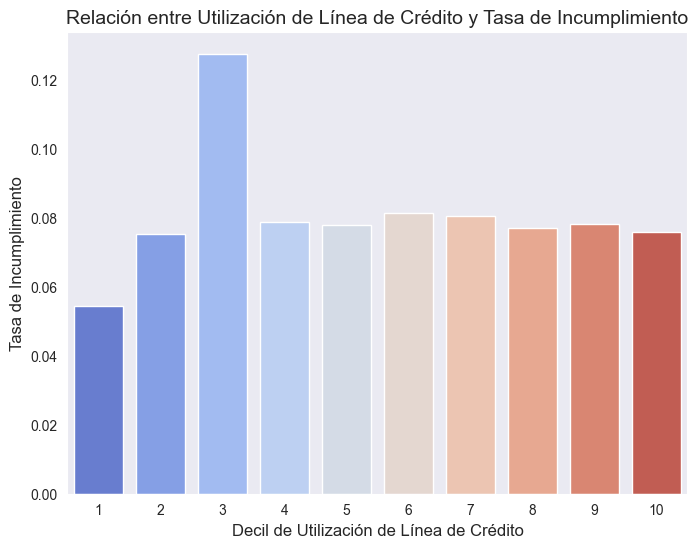

In [13]:
plt.figure(figsize=(8, 6))
sns.barplot(
    x = "utilization_decile", 
    y = "default_rate", 
    data = preg_05, 
    palette = "coolwarm")
plt.title("Relaci√≥n entre Utilizaci√≥n de L√≠nea de Cr√©dito y Tasa de Incumplimiento", fontsize = 14)
plt.xlabel("Decil de Utilizaci√≥n de L√≠nea de Cr√©dito", fontsize = 12)
plt.ylabel("Tasa de Incumplimiento", fontsize = 12)
plt.savefig('./figs/preg05.png', dpi = 300)
plt.show()

**`Respuesta`:** Notar que la grafica anterior, es similar al de la pregunta 05. El comportamiento similar en ambas gr√°ficas refleja c√≥mo el saldo promedio y la utilizaci√≥n de la l√≠nea de cr√©dito son indicadores relacionados del riesgo de incumplimiento. Ambos factores est√°n vinculados a la capacidad de pago, el nivel de endeudamiento y los h√°bitos financieros de los clientes. Por otro lado, el saldo promedio en la tarjeta de cr√©dito (`AMT_BALANCE`) est√° directamente relacionado con la utilizaci√≥n de la l√≠nea de cr√©dito (`AMT_BALANCE / AMT_CREDIT_LIMIT_ACTUAL`). Si un cliente tiene un saldo alto, es probable que est√© utilizando una mayor proporci√≥n de su l√≠mite de cr√©dito, lo que explica el comportamiento similar en ambas gr√°ficas.

#### üìå `Pregunta 6.`

¬øLos clientes cuyos cr√©ditos previos fueron rechazados tienen una mayor probabilidad de incumplir en futuras solicitudes ?

In [14]:
## Query
preg_06 = pd.read_sql_query("""
WITH refused_clients AS (
  SELECT 
    SK_ID_CURR,
    COUNT(*) AS refused_count
  FROM previous_application
  WHERE NAME_CONTRACT_STATUS = 'Refused'
  GROUP BY SK_ID_CURR
),
clients_flagged AS (
  SELECT 
    a.SK_ID_CURR,
    a.TARGET,
    CASE WHEN r.refused_count IS NOT NULL THEN 1 ELSE 0 END AS had_refusals
  FROM application_train a
  LEFT JOIN refused_clients r ON a.SK_ID_CURR = r.SK_ID_CURR
)
SELECT 
  had_refusals,
  COUNT(*) AS total_clients,
  SUM(TARGET) AS total_defaults,
  ROUND(SUM(TARGET) * 1.0 / COUNT(*), 4) AS default_rate
FROM clients_flagged
GROUP BY had_refusals;
""", conn)

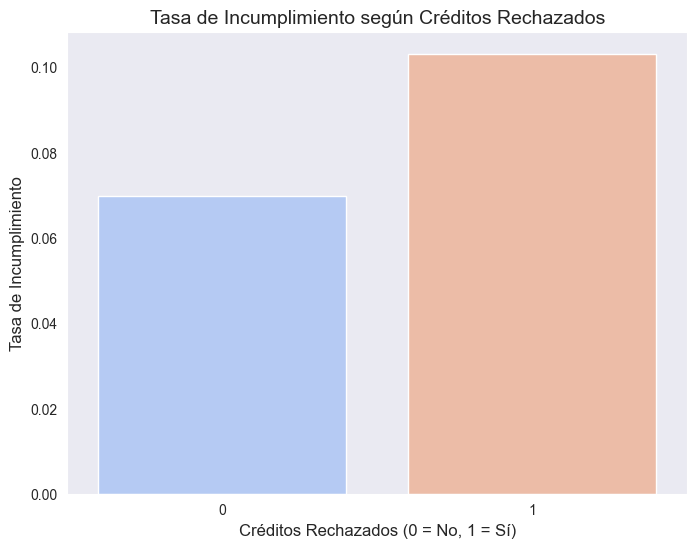

In [15]:
plt.figure(figsize=(8, 6))
sns.barplot(
    x = "had_refusals", 
    y = "default_rate", 
    data = preg_06, 
    palette = "coolwarm")
plt.title("Tasa de Incumplimiento seg√∫n Cr√©ditos Rechazados", fontsize = 14)
plt.xlabel("Cr√©ditos Rechazados (0 = No, 1 = S√≠)", fontsize = 12)
plt.ylabel("Tasa de Incumplimiento", fontsize = 12)
plt.savefig('./figs/preg06.png', dpi = 300)
plt.show()

**`Respuesta`:** S√≠, los clientes cuyos cr√©ditos previos fueron rechazados tienen una mayor probabilidad de incumplir en futuras solicitudes, como lo demuestra la diferencia en las tasas de incumplimiento entre ambos grupos.

#### üìå `Pregunta 7.`

¬øCu√°l es la tasa de default de clientes que viven con su familia (`NAME_TYPE_SUITE = 'Family'`) y que tienen al menos un hijo (`CNT_CHILDREN > 0`), en comparaci√≥n con quienes viven solos y sin hijos, segmentado por deciles de ingreso ?

In [16]:
## Query
preg_07 = pd.read_sql_query("""
WITH labeled_clients AS (
  SELECT 
    SK_ID_CURR,
    TARGET,
    AMT_INCOME_TOTAL,
    CASE 
      WHEN NAME_TYPE_SUITE = 'Family' AND CNT_CHILDREN > 0 THEN 'With_Family_and_Children'
      WHEN NAME_TYPE_SUITE = 'Unaccompanied' AND CNT_CHILDREN = 0 THEN 'Alone_No_Children'
      ELSE 'Other'
    END AS group_type
  FROM application_train
),
income_deciles AS (
  SELECT *,
    NTILE(10) OVER (ORDER BY AMT_INCOME_TOTAL) AS income_decile
  FROM labeled_clients
)
SELECT 
  group_type,
  income_decile,
  COUNT(*) AS total_clients,
  SUM(TARGET) AS total_defaults,
  ROUND(SUM(TARGET) * 1.0 / COUNT(*), 4) AS default_rate
FROM income_deciles
WHERE group_type IN ('With_Family_and_Children', 'Alone_No_Children')
GROUP BY group_type, income_decile
ORDER BY group_type, income_decile;
""", conn)

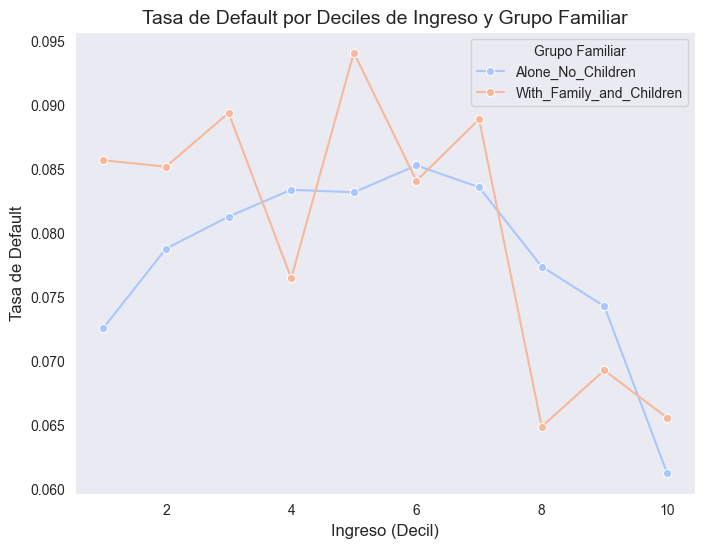

In [17]:
plt.figure(figsize=(8, 6))
sns.lineplot(
    x = "income_decile", 
    y = "default_rate", 
    hue = "group_type", 
    data = preg_07, 
    marker = "o", 
    palette = "coolwarm")
plt.title("Tasa de Default por Deciles de Ingreso y Grupo Familiar", fontsize = 14)
plt.xlabel("Ingreso (Decil)", fontsize = 12)
plt.ylabel("Tasa de Default", fontsize = 12)
plt.legend(title = "Grupo Familiar")
plt.savefig('./figs/preg07.png', dpi = 300)
plt.show()

**`Respuesta`:** Los clientes que viven con su familia y tienen al menos un hijo presentan una mayor tasa de default en comparaci√≥n con quienes viven solos y sin hijos, especialmente en los deciles bajos y medios de ingreso. Esto sugiere que el perfil familiar y el nivel de ingreso son factores importantes para evaluar el riesgo de incumplimiento.

#### üìå `Pregunta 8.`

¬øC√≥mo var√≠a la tasa de default entre personas que viven en departamentos alquilados o comunales y tienen educaci√≥n secundaria o menor, en comparaci√≥n con quienes son propietarios con educaci√≥n superior, segmentado por deciles de ingreso?


In [18]:
## Query
preg_08 = pd.read_sql_query("""
WITH categorized_clients AS (
  SELECT 
    SK_ID_CURR,
    TARGET,
    AMT_INCOME_TOTAL,
    CASE 
      WHEN NAME_HOUSING_TYPE IN ('Rented apartment', 'Municipal apartment') 
        AND NAME_EDUCATION_TYPE IN ('Secondary / secondary special', 'Lower secondary') 
        THEN 'Low_Edu_Rent'
      WHEN NAME_HOUSING_TYPE = 'House / apartment' 
        AND NAME_EDUCATION_TYPE = 'Higher education'
        THEN 'High_Edu_Owner'
      ELSE 'Other'
    END AS profile_type
  FROM application_train
),
income_deciles AS (
  SELECT *,
    NTILE(10) OVER (ORDER BY AMT_INCOME_TOTAL) AS income_decile
  FROM categorized_clients
)
SELECT 
  profile_type,
  income_decile,
  COUNT(*) AS total_clients,
  SUM(TARGET) AS total_defaults,
  ROUND(SUM(TARGET) * 1.0 / COUNT(*), 4) AS default_rate
FROM income_deciles
WHERE profile_type IN ('Low_Edu_Rent', 'High_Edu_Owner')
GROUP BY profile_type, income_decile
ORDER BY profile_type, income_decile;
""", conn)

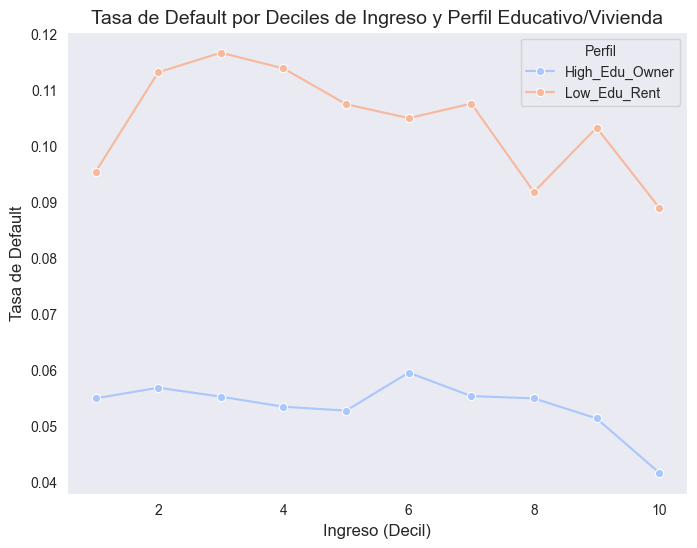

In [19]:
plt.figure(figsize=(8, 6))
sns.lineplot(
    x = "income_decile", 
    y = "default_rate", 
    hue = "profile_type", 
    data = preg_08, 
    marker = "o", 
    palette = "coolwarm")
plt.title("Tasa de Default por Deciles de Ingreso y Perfil Educativo/Vivienda", fontsize = 14)
plt.xlabel("Ingreso (Decil)", fontsize = 12)
plt.ylabel("Tasa de Default", fontsize = 12)
plt.legend(title = "Perfil")
plt.savefig('./figs/preg08.png', dpi = 300)
plt.show()

**`Respuesta`:** Las personas que viven en departamentos alquilados o comunales y tienen educaci√≥n secundaria o menor presentan una mayor tasa de default en comparaci√≥n con quienes son propietarios con educaci√≥n superior, especialmente en los deciles bajos de ingreso. Esto refuerza la importancia de considerar el perfil educativo y la situaci√≥n de vivienda al evaluar el riesgo de incumplimiento.

In [20]:
# Cierre conexi√≥n
conn.close()